In [84]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from utils import *
sns.set()


In [61]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, average_precision_score, fbeta_score
from sklearn.model_selection import GridSearchCV
import optuna

In [62]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_valid = pd.read_csv("valid.csv")

In [63]:
X_train, y_train, X_valid, y_valid, X_test, y_test = get_train_and_test_values(df_train, df_valid, df_test)

In [64]:
from collections import Counter
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0, sampling_strategy=0.6)

X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

print(sorted(Counter(y_train_resampled).items()))
print(sorted(Counter(y_test).items()))
print(sorted(Counter(y_valid).items()))

[(0, 6582), (1, 5946)]
[(0, 2131), (1, 134)]
[(0, 2131), (1, 134)]


### Optuna Hyperparameter Tuning

#### Finding hyperparameter with the best recall

In [65]:
#creating an objective function
def objective(trial):
    
    #hyperparameters to tune
    param = {
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 9),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 1e-8, 1.0),
        'n_estimators': trial.suggest_int("n_estimators", 1, 1000),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight",1, 25)
    }

    #creating the model
    xgbr = XGBClassifier(seed = 20, **param)
    xgbr.fit(X_train_resampled, y_train_resampled)

    #classifying validation data
    y_pred = xgbr.predict(X_valid)

    #measuring the evaluation metrics for the model
    recall = metrics.recall_score(y_valid, y_pred)
    return recall

In [66]:
#running 100 trials to find the hyperparameters that give the highest evaluation metric score
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial : objective(trial) ,n_trials=100)
print("Number of finished trials: ", len(study.trials))

[I 2022-11-16 14:00:55,703] A new study created in memory with name: no-name-609fd888-0b5b-43b7-8a68-0bb72a191021
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:10: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\L

[14:00:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:00:59,003] Trial 0 finished with value: 1.0 and parameters: {'lambda': 0.0014229083961947056, 'min_child_weight': 4, 'alpha': 1.0326918666930684e-06, 'max_depth': 1, 'eta': 8.75114630115611e-05, 'gamma': 8.250082900512612e-06, 'grow_policy': 'lossguide', 'colsample_bytree': 0.3394051835143866, 'n_estimators': 649, 'scale_pos_weight': 12}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\i

[14:00:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:01:01,715] Trial 1 finished with value: 0.9925373134328358 and parameters: {'lambda': 4.264450163636165e-06, 'min_child_weight': 4, 'alpha': 0.007183411562449294, 'max_depth': 3, 'eta': 0.0475689840133077, 'gamma': 2.6711553039849714e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0.8670203511106405, 'n_estimators': 219, 'scale_pos_weight': 19}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\

[14:01:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:01:02,372] Trial 2 finished with value: 1.0 and parameters: {'lambda': 1.821921812017427e-05, 'min_child_weight': 3, 'alpha': 0.010612764945892484, 'max_depth': 5, 'eta': 0.0005768738044847012, 'gamma': 0.006153780302822595, 'grow_policy': 'lossguide', 'colsample_bytree': 3.9943143936825605e-07, 'n_estimators': 121, 'scale_pos_weight': 4}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\

[14:01:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:01:02,803] Trial 3 finished with value: 1.0 and parameters: {'lambda': 3.525644084404203e-05, 'min_child_weight': 3, 'alpha': 7.050500456802078e-08, 'max_depth': 1, 'eta': 0.00015787886158013628, 'gamma': 0.000420350866110892, 'grow_policy': 'lossguide', 'colsample_bytree': 0.0003576712488495436, 'n_estimators': 114, 'scale_pos_weight': 22}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Tem

[14:01:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:01:06,400] Trial 4 finished with value: 1.0 and parameters: {'lambda': 0.003543289533922017, 'min_child_weight': 1, 'alpha': 0.001377698740852999, 'max_depth': 4, 'eta': 0.0002605807358760381, 'gamma': 0.0034000417852898253, 'grow_policy': 'lossguide', 'colsample_bytree': 0.004436491145324321, 'n_estimators': 745, 'scale_pos_weight': 14}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\i

[14:01:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:01:14,798] Trial 5 finished with value: 0.5746268656716418 and parameters: {'lambda': 1.0046589424434884e-07, 'min_child_weight': 3, 'alpha': 5.669670771054071e-07, 'max_depth': 3, 'eta': 0.09832632930914031, 'gamma': 6.422654685240454e-08, 'grow_policy': 'lossguide', 'colsample_bytree': 0.24508536185168145, 'n_estimators': 992, 'scale_pos_weight': 2}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppDat

[14:01:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:01:18,043] Trial 6 finished with value: 1.0 and parameters: {'lambda': 0.26458223840441214, 'min_child_weight': 8, 'alpha': 0.0006653710035247173, 'max_depth': 4, 'eta': 2.2278828349481363e-05, 'gamma': 0.04303904029494121, 'grow_policy': 'lossguide', 'colsample_bytree': 2.0104352653312244e-06, 'n_estimators': 553, 'scale_pos_weight': 4}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\i

[14:01:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:01:22,067] Trial 7 finished with value: 1.0 and parameters: {'lambda': 0.004589958776235819, 'min_child_weight': 9, 'alpha': 1.8546305505577567e-06, 'max_depth': 6, 'eta': 0.009075026999140107, 'gamma': 5.558262730052714e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0.0012284313356879918, 'n_estimators': 694, 'scale_pos_weight': 10}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp

[14:01:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:01:23,479] Trial 8 finished with value: 1.0 and parameters: {'lambda': 3.3157186340100896e-05, 'min_child_weight': 5, 'alpha': 0.000162262278200596, 'max_depth': 2, 'eta': 7.533227264549059e-07, 'gamma': 8.078774513253672e-08, 'grow_policy': 'depthwise', 'colsample_bytree': 4.193170213816002e-07, 'n_estimators': 281, 'scale_pos_weight': 16}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Tem

[14:01:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:01:28,850] Trial 9 finished with value: 0.664179104477612 and parameters: {'lambda': 9.82126349703666e-07, 'min_child_weight': 2, 'alpha': 1.2841737137183214e-07, 'max_depth': 6, 'eta': 0.03106621755405234, 'gamma': 0.0048766208478713945, 'grow_policy': 'depthwise', 'colsample_bytree': 9.876740918465678e-05, 'n_estimators': 700, 'scale_pos_weight': 15}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppDa

[14:01:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:01:31,695] Trial 10 finished with value: 1.0 and parameters: {'lambda': 0.001994082530866485, 'min_child_weight': 7, 'alpha': 0.832373710266809, 'max_depth': 9, 'eta': 2.5388021918620564e-08, 'gamma': 1.4250897574515337e-05, 'grow_policy': 'depthwise', 'colsample_bytree': 1.1539370564335971e-08, 'n_estimators': 406, 'scale_pos_weight': 9}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\

[14:01:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:01:32,228] Trial 11 finished with value: 1.0 and parameters: {'lambda': 0.0004450943379738865, 'min_child_weight': 6, 'alpha': 0.08002049103114431, 'max_depth': 7, 'eta': 0.001334179027042782, 'gamma': 1.9413525795237013e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 6.634838486537636e-06, 'n_estimators': 32, 'scale_pos_weight': 7}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\i

[14:01:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:01:35,447] Trial 12 finished with value: 0.0 and parameters: {'lambda': 0.22357959168915228, 'min_child_weight': 5, 'alpha': 7.632490313787363e-06, 'max_depth': 9, 'eta': 2.064041541955351e-06, 'gamma': 0.7430824671535462, 'grow_policy': 'lossguide', 'colsample_bytree': 0.019643104788281022, 'n_estimators': 532, 'scale_pos_weight': 1}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipyk

[14:01:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:01:39,140] Trial 13 finished with value: 1.0 and parameters: {'lambda': 1.099589951560719e-08, 'min_child_weight': 3, 'alpha': 1.4135602372678176e-05, 'max_depth': 1, 'eta': 8.366649108649595e-06, 'gamma': 5.2020576541002206e-06, 'grow_policy': 'lossguide', 'colsample_bytree': 5.096580743337732e-08, 'n_estimators': 899, 'scale_pos_weight': 25}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\

[14:01:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:01:41,512] Trial 14 finished with value: 0.6119402985074627 and parameters: {'lambda': 0.00021062741244148032, 'min_child_weight': 1, 'alpha': 1.3193802097985038e-08, 'max_depth': 7, 'eta': 0.5836358224459973, 'gamma': 0.0005852671630623643, 'grow_policy': 'lossguide', 'colsample_bytree': 7.812402150531451e-05, 'n_estimators': 369, 'scale_pos_weight': 6}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\App

[14:01:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:01:45,032] Trial 15 finished with value: 1.0 and parameters: {'lambda': 0.017007845469805948, 'min_child_weight': 4, 'alpha': 0.06497671585024432, 'max_depth': 5, 'eta': 0.0011856587896259911, 'gamma': 0.05675297697290667, 'grow_policy': 'depthwise', 'colsample_bytree': 1.2285826344113955e-05, 'n_estimators': 631, 'scale_pos_weight': 11}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\i

[14:01:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:01:47,759] Trial 16 finished with value: 1.0 and parameters: {'lambda': 3.496289963338182e-06, 'min_child_weight': 4, 'alpha': 3.9703350429883885e-05, 'max_depth': 2, 'eta': 1.7516033973491808e-07, 'gamma': 2.257467477749642e-06, 'grow_policy': 'lossguide', 'colsample_bytree': 0.038996598047126546, 'n_estimators': 428, 'scale_pos_weight': 18}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\T

[14:01:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:01:52,399] Trial 17 finished with value: 1.0 and parameters: {'lambda': 3.393357289206685e-08, 'min_child_weight': 6, 'alpha': 1.3032018428360387e-05, 'max_depth': 1, 'eta': 1.5489644464535774e-05, 'gamma': 6.364309473721109e-06, 'grow_policy': 'lossguide', 'colsample_bytree': 1.3350157136710194e-08, 'n_estimators': 901, 'scale_pos_weight': 25}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local

[14:01:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:01:55,557] Trial 18 finished with value: 1.0 and parameters: {'lambda': 0.033081413980563044, 'min_child_weight': 4, 'alpha': 0.7069935480629808, 'max_depth': 8, 'eta': 3.962204031081717e-05, 'gamma': 1.0368836275279012e-08, 'grow_policy': 'depthwise', 'colsample_bytree': 1.3227759156870468e-05, 'n_estimators': 621, 'scale_pos_weight': 11}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp

[14:01:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:01:57,907] Trial 19 finished with value: 1.0 and parameters: {'lambda': 3.7095895993907813e-07, 'min_child_weight': 6, 'alpha': 5.752793183078632e-05, 'max_depth': 2, 'eta': 2.6479404067654856e-08, 'gamma': 0.00011691053154648875, 'grow_policy': 'lossguide', 'colsample_bytree': 0.041636998288440995, 'n_estimators': 438, 'scale_pos_weight': 18}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\

[14:01:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:02:00,555] Trial 20 finished with value: 1.0 and parameters: {'lambda': 1.2751764962591743e-08, 'min_child_weight': 7, 'alpha': 1.5207357317746036e-06, 'max_depth': 1, 'eta': 5.172845716421835e-06, 'gamma': 9.391802702091719e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 6.106281813744278e-08, 'n_estimators': 818, 'scale_pos_weight': 25}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\

[14:02:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:02:05,858] Trial 21 finished with value: 1.0 and parameters: {'lambda': 0.04894916880572551, 'min_child_weight': 5, 'alpha': 4.896302986116224e-06, 'max_depth': 8, 'eta': 4.143072111676967e-05, 'gamma': 2.7135395100084872e-08, 'grow_policy': 'depthwise', 'colsample_bytree': 2.542006467093397e-05, 'n_estimators': 830, 'scale_pos_weight': 12}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Tem

[14:02:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:02:08,242] Trial 22 finished with value: 1.0 and parameters: {'lambda': 0.04176966355564123, 'min_child_weight': 6, 'alpha': 0.0002557875214180905, 'max_depth': 2, 'eta': 1.717506777230494e-08, 'gamma': 9.593573345377116e-05, 'grow_policy': 'depthwise', 'colsample_bytree': 0.08774936773754585, 'n_estimators': 585, 'scale_pos_weight': 18}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\i

[14:02:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:02:10,994] Trial 23 finished with value: 1.0 and parameters: {'lambda': 2.830502591200308e-07, 'min_child_weight': 7, 'alpha': 6.5847971979196e-07, 'max_depth': 1, 'eta': 7.886346959915625e-08, 'gamma': 9.135991330455032e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0.006823178331045728, 'n_estimators': 758, 'scale_pos_weight': 22}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\

[14:02:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:02:15,074] Trial 24 finished with value: 1.0 and parameters: {'lambda': 0.6455963110914336, 'min_child_weight': 7, 'alpha': 2.551485125425783e-06, 'max_depth': 3, 'eta': 2.097779172023488e-06, 'gamma': 1.5601867122968058e-08, 'grow_policy': 'depthwise', 'colsample_bytree': 1.3138727024641465e-07, 'n_estimators': 833, 'scale_pos_weight': 13}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Tem

[14:02:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:02:24,823] Trial 25 finished with value: 1.0 and parameters: {'lambda': 0.03801513581922264, 'min_child_weight': 5, 'alpha': 0.00024904772294519206, 'max_depth': 8, 'eta': 0.004311527373306522, 'gamma': 7.853313510493606e-07, 'grow_policy': 'depthwise', 'colsample_bytree': 0.20266022784984164, 'n_estimators': 585, 'scale_pos_weight': 13}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\i

[14:02:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:02:27,536] Trial 26 finished with value: 1.0 and parameters: {'lambda': 0.0008039754223277783, 'min_child_weight': 8, 'alpha': 4.3877377597511114e-07, 'max_depth': 2, 'eta': 1.9321610387913436e-07, 'gamma': 6.856885038478588e-05, 'grow_policy': 'depthwise', 'colsample_bytree': 0.005721177998133116, 'n_estimators': 737, 'scale_pos_weight': 21}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\T

[14:02:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:02:37,310] Trial 27 finished with value: 1.0 and parameters: {'lambda': 0.43187171596409046, 'min_child_weight': 7, 'alpha': 1.1812728030161927e-08, 'max_depth': 3, 'eta': 3.241104989876796e-07, 'gamma': 0.000937534072341999, 'grow_policy': 'depthwise', 'colsample_bytree': 0.7953757407880013, 'n_estimators': 816, 'scale_pos_weight': 8}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipy

[14:02:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:02:40,962] Trial 28 finished with value: 1.0 and parameters: {'lambda': 0.007501705269032381, 'min_child_weight': 8, 'alpha': 1.151131882780191e-07, 'max_depth': 4, 'eta': 0.0070911029071596705, 'gamma': 7.208193051224282e-07, 'grow_policy': 'depthwise', 'colsample_bytree': 0.18720553272076715, 'n_estimators': 490, 'scale_pos_weight': 13}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\

[14:02:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:02:49,966] Trial 29 finished with value: 1.0 and parameters: {'lambda': 0.0005509187909387885, 'min_child_weight': 9, 'alpha': 0.003481840901420291, 'max_depth': 6, 'eta': 0.002672061078908703, 'gamma': 1.5277387262844621e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0.44719056383343814, 'n_estimators': 657, 'scale_pos_weight': 16}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\

[14:02:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:02:59,585] Trial 30 finished with value: 1.0 and parameters: {'lambda': 0.0010814319283126907, 'min_child_weight': 8, 'alpha': 1.1815278345265502e-08, 'max_depth': 3, 'eta': 4.2880379430439614e-07, 'gamma': 0.0008507418183715356, 'grow_policy': 'depthwise', 'colsample_bytree': 0.8272732410073661, 'n_estimators': 992, 'scale_pos_weight': 7}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp

[14:02:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:03:05,970] Trial 31 finished with value: 0.9776119402985075 and parameters: {'lambda': 0.008126503370106264, 'min_child_weight': 8, 'alpha': 6.2563195593178e-08, 'max_depth': 4, 'eta': 1.1545608204213444e-07, 'gamma': 2.726875578703167e-05, 'grow_policy': 'depthwise', 'colsample_bytree': 0.845049825878559, 'n_estimators': 482, 'scale_pos_weight': 8}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\

[14:03:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:03:12,809] Trial 32 finished with value: 0.9850746268656716 and parameters: {'lambda': 0.0001052615959556585, 'min_child_weight': 9, 'alpha': 3.09312163193425e-08, 'max_depth': 5, 'eta': 0.012924820121098161, 'gamma': 1.5398971675493642e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0.3394856026168846, 'n_estimators': 663, 'scale_pos_weight': 16}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppDa

[14:03:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:03:15,520] Trial 33 finished with value: 0.7611940298507462 and parameters: {'lambda': 0.000989593147458178, 'min_child_weight': 9, 'alpha': 1.5245928638065148e-07, 'max_depth': 6, 'eta': 0.14598227620984133, 'gamma': 2.4103198208162536e-07, 'grow_policy': 'depthwise', 'colsample_bytree': 0.12944926951611616, 'n_estimators': 326, 'scale_pos_weight': 5}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppDa

[14:03:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:03:19,391] Trial 34 finished with value: 1.0 and parameters: {'lambda': 0.00022096371520763253, 'min_child_weight': 8, 'alpha': 0.003185346141030691, 'max_depth': 4, 'eta': 0.0003446999182939402, 'gamma': 2.1553389819015228e-07, 'grow_policy': 'depthwise', 'colsample_bytree': 0.8920968768426975, 'n_estimators': 243, 'scale_pos_weight': 14}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp

[14:03:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:03:22,023] Trial 35 finished with value: 1.0 and parameters: {'lambda': 1.0431996331906398e-05, 'min_child_weight': 9, 'alpha': 2.2559933745241214e-07, 'max_depth': 5, 'eta': 0.00011147186610311181, 'gamma': 5.6206762838365635e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0.016417962884408693, 'n_estimators': 502, 'scale_pos_weight': 20}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local

[14:03:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:03:26,069] Trial 36 finished with value: 1.0 and parameters: {'lambda': 0.0018870490638496034, 'min_child_weight': 9, 'alpha': 0.015061706157017834, 'max_depth': 3, 'eta': 0.002562486229087848, 'gamma': 0.0019295299333481584, 'grow_policy': 'depthwise', 'colsample_bytree': 0.0012407834800924448, 'n_estimators': 992, 'scale_pos_weight': 16}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp

[14:03:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:03:28,144] Trial 37 finished with value: 1.0 and parameters: {'lambda': 0.00013417864351861425, 'min_child_weight': 8, 'alpha': 0.002115629780236102, 'max_depth': 4, 'eta': 0.0002891999856886716, 'gamma': 1.1405108957210584e-07, 'grow_policy': 'depthwise', 'colsample_bytree': 0.8896053029745841, 'n_estimators': 110, 'scale_pos_weight': 3}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\

[14:03:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:03:30,814] Trial 38 finished with value: 1.0 and parameters: {'lambda': 1.462677882689713e-07, 'min_child_weight': 5, 'alpha': 5.226262437823178e-05, 'max_depth': 1, 'eta': 5.7703051930687496e-06, 'gamma': 0.00029559195507526334, 'grow_policy': 'lossguide', 'colsample_bytree': 0.000614281094835149, 'n_estimators': 825, 'scale_pos_weight': 23}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\T

[14:03:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:03:34,521] Trial 39 finished with value: 1.0 and parameters: {'lambda': 0.12613990606399658, 'min_child_weight': 6, 'alpha': 3.10395971499414e-06, 'max_depth': 2, 'eta': 7.260406993517608e-05, 'gamma': 0.010426507677113148, 'grow_policy': 'lossguide', 'colsample_bytree': 1.0553108928662612e-06, 'n_estimators': 883, 'scale_pos_weight': 11}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\

[14:03:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:03:37,446] Trial 40 finished with value: 1.0 and parameters: {'lambda': 0.07164707901500346, 'min_child_weight': 3, 'alpha': 0.0006791520555237359, 'max_depth': 1, 'eta': 1.3316250580653973e-08, 'gamma': 0.00021176981439541048, 'grow_policy': 'lossguide', 'colsample_bytree': 5.5258595123902224e-05, 'n_estimators': 773, 'scale_pos_weight': 18}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\T

[14:03:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:03:40,746] Trial 41 finished with value: 1.0 and parameters: {'lambda': 0.9681836233194958, 'min_child_weight': 7, 'alpha': 1.0152201474255218e-06, 'max_depth': 2, 'eta': 5.734507903052326e-08, 'gamma': 5.7877432463884345e-08, 'grow_policy': 'lossguide', 'colsample_bytree': 0.06755072259944646, 'n_estimators': 731, 'scale_pos_weight': 12}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\

[14:03:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:03:43,527] Trial 42 finished with value: 1.0 and parameters: {'lambda': 0.7564990324012175, 'min_child_weight': 6, 'alpha': 4.29455991557537e-06, 'max_depth': 1, 'eta': 1.4859000641255352e-06, 'gamma': 1.1757442664591695e-08, 'grow_policy': 'depthwise', 'colsample_bytree': 0.00026114187061157534, 'n_estimators': 868, 'scale_pos_weight': 22}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Tem

[14:03:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:03:45,969] Trial 43 finished with value: 1.0 and parameters: {'lambda': 0.02096723981327126, 'min_child_weight': 5, 'alpha': 0.00027905250077088733, 'max_depth': 2, 'eta': 6.510433474848382e-08, 'gamma': 1.6961906262992374e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0.006559396300636023, 'n_estimators': 585, 'scale_pos_weight': 14}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Tem

[14:03:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:03:48,983] Trial 44 finished with value: 1.0 and parameters: {'lambda': 0.13219706770228423, 'min_child_weight': 7, 'alpha': 0.0001854765048641977, 'max_depth': 3, 'eta': 1.1061723485808757e-08, 'gamma': 4.4006771577938834e-05, 'grow_policy': 'depthwise', 'colsample_bytree': 0.09928053702877772, 'n_estimators': 585, 'scale_pos_weight': 19}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp

[14:03:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:03:51,601] Trial 45 finished with value: 1.0 and parameters: {'lambda': 2.428645747718737e-05, 'min_child_weight': 2, 'alpha': 4.619473304056839e-07, 'max_depth': 1, 'eta': 1.230025531829423e-06, 'gamma': 5.353108229413689e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0.005029226440046543, 'n_estimators': 757, 'scale_pos_weight': 21}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Tem

[14:03:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:03:54,198] Trial 46 finished with value: 1.0 and parameters: {'lambda': 5.084190006438576e-05, 'min_child_weight': 4, 'alpha': 4.769840522674979e-07, 'max_depth': 2, 'eta': 2.4722163397626836e-06, 'gamma': 3.554490978724093e-05, 'grow_policy': 'depthwise', 'colsample_bytree': 0.00249250829924515, 'n_estimators': 695, 'scale_pos_weight': 13}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Tem

[14:03:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:03:58,300] Trial 47 finished with value: 1.0 and parameters: {'lambda': 0.3332750204671699, 'min_child_weight': 7, 'alpha': 3.8569636319463966e-08, 'max_depth': 3, 'eta': 2.9999304103555034e-07, 'gamma': 0.010521846791034257, 'grow_policy': 'depthwise', 'colsample_bytree': 0.017064546118424388, 'n_estimators': 799, 'scale_pos_weight': 10}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\

[14:03:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:00,814] Trial 48 finished with value: 1.0 and parameters: {'lambda': 0.3912734886588919, 'min_child_weight': 5, 'alpha': 1.844873917062792e-05, 'max_depth': 3, 'eta': 4.926863963104172e-07, 'gamma': 8.027509144795751e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0.22617744159638242, 'n_estimators': 701, 'scale_pos_weight': 9}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipy

[14:04:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:03,300] Trial 49 finished with value: 0.9925373134328358 and parameters: {'lambda': 0.0029333203181886613, 'min_child_weight': 8, 'alpha': 9.5162887538812e-08, 'max_depth': 4, 'eta': 0.037966533454768164, 'gamma': 1.0146871652937332e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0.19848914291118167, 'n_estimators': 556, 'scale_pos_weight': 15}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppDa

[14:04:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:04,911] Trial 50 finished with value: 1.0 and parameters: {'lambda': 0.008241192202275649, 'min_child_weight': 4, 'alpha': 3.0638039187316594e-07, 'max_depth': 7, 'eta': 0.013095621505043049, 'gamma': 2.850768639759113e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0.03453520873071178, 'n_estimators': 491, 'scale_pos_weight': 9}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\i

[14:04:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:10,511] Trial 51 finished with value: 1.0 and parameters: {'lambda': 0.0006481634503827427, 'min_child_weight': 8, 'alpha': 1.3817706763091495e-08, 'max_depth': 3, 'eta': 0.0009706605630151177, 'gamma': 0.0007386359455562859, 'grow_policy': 'depthwise', 'colsample_bytree': 0.3231063614434257, 'n_estimators': 944, 'scale_pos_weight': 7}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\

[14:04:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:21,207] Trial 52 finished with value: 1.0 and parameters: {'lambda': 0.0011766884887934015, 'min_child_weight': 9, 'alpha': 2.1919199897418063e-08, 'max_depth': 6, 'eta': 4.334343992339124e-07, 'gamma': 0.0009727722726903888, 'grow_policy': 'depthwise', 'colsample_bytree': 0.4350951879460945, 'n_estimators': 936, 'scale_pos_weight': 6}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\

[14:04:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:28,802] Trial 53 finished with value: 1.0 and parameters: {'lambda': 0.0004436664621356592, 'min_child_weight': 8, 'alpha': 1.346065492780962e-08, 'max_depth': 4, 'eta': 0.000633938050399396, 'gamma': 0.0019163192210318912, 'grow_policy': 'depthwise', 'colsample_bytree': 0.4898609791046636, 'n_estimators': 951, 'scale_pos_weight': 7}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ip

[14:04:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:31,362] Trial 54 finished with value: 1.0 and parameters: {'lambda': 0.0060306495061052245, 'min_child_weight': 8, 'alpha': 0.004102308868202528, 'max_depth': 4, 'eta': 0.0035764683061940503, 'gamma': 2.761812572045464e-07, 'grow_policy': 'depthwise', 'colsample_bytree': 0.9076253733787227, 'n_estimators': 207, 'scale_pos_weight': 15}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\i

[14:04:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:33,309] Trial 55 finished with value: 1.0 and parameters: {'lambda': 0.00021136733274650386, 'min_child_weight': 8, 'alpha': 0.05500760271430239, 'max_depth': 5, 'eta': 0.00026357122227873967, 'gamma': 0.0023424639664829535, 'grow_policy': 'depthwise', 'colsample_bytree': 0.4306222898846091, 'n_estimators': 178, 'scale_pos_weight': 4}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\i

[14:04:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:34,414] Trial 56 finished with value: 1.0 and parameters: {'lambda': 1.3314701467752792e-05, 'min_child_weight': 9, 'alpha': 2.0126773903524552e-07, 'max_depth': 5, 'eta': 0.00012856817614488892, 'gamma': 4.004033441482155e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0.015221480772257278, 'n_estimators': 277, 'scale_pos_weight': 17}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\

[14:04:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:35,413] Trial 57 finished with value: 1.0 and parameters: {'lambda': 0.0002852197245810895, 'min_child_weight': 9, 'alpha': 0.029628595181019155, 'max_depth': 5, 'eta': 0.00026815249720274985, 'gamma': 3.041618757946119e-07, 'grow_policy': 'depthwise', 'colsample_bytree': 0.04155837095939361, 'n_estimators': 205, 'scale_pos_weight': 2}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\

[14:04:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:39,192] Trial 58 finished with value: 1.0 and parameters: {'lambda': 8.352385810242936e-06, 'min_child_weight': 9, 'alpha': 0.006871597199558163, 'max_depth': 6, 'eta': 0.002353379485759842, 'gamma': 0.1873695829479149, 'grow_policy': 'depthwise', 'colsample_bytree': 0.0015899711588571973, 'n_estimators': 977, 'scale_pos_weight': 16}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ip

[14:04:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:39,703] Trial 59 finished with value: 1.0 and parameters: {'lambda': 1.8749939203391344e-06, 'min_child_weight': 9, 'alpha': 0.05262423501416706, 'max_depth': 5, 'eta': 2.2742920059035757e-05, 'gamma': 2.6790714823457333e-07, 'grow_policy': 'depthwise', 'colsample_bytree': 0.04907259555701154, 'n_estimators': 92, 'scale_pos_weight': 2}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\

[14:04:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:10: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This

[14:04:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:40,417] Trial 61 finished with value: 1.0 and parameters: {'lambda': 2.6321599379451823e-06, 'min_child_weight': 9, 'alpha': 0.0013883545301787172, 'max_depth': 5, 'eta': 1.096877491731587e-05, 'gamma': 0.00022419173409867957, 'grow_policy': 'lossguide', 'colsample_bytree': 0.0005428554736017976, 'n_estimators': 106, 'scale_pos_weight': 24}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\

[14:04:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:42,906] Trial 62 finished with value: 1.0 and parameters: {'lambda': 1.2499790407207495e-07, 'min_child_weight': 6, 'alpha': 0.17629509224286585, 'max_depth': 1, 'eta': 6.791522856772649e-05, 'gamma': 0.013762116689260985, 'grow_policy': 'lossguide', 'colsample_bytree': 2.9263864631356262e-06, 'n_estimators': 877, 'scale_pos_weight': 23}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Tem

[14:04:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:43,467] Trial 63 finished with value: 1.0 and parameters: {'lambda': 4.272902319257782e-05, 'min_child_weight': 4, 'alpha': 6.097860777955587e-05, 'max_depth': 2, 'eta': 7.744012972744293e-05, 'gamma': 0.004568890499874926, 'grow_policy': 'lossguide', 'colsample_bytree': 0.0007860446430573033, 'n_estimators': 70, 'scale_pos_weight': 11}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp

[14:04:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:44,608] Trial 64 finished with value: 1.0 and parameters: {'lambda': 0.0022034649696526425, 'min_child_weight': 5, 'alpha': 0.0007853324521094918, 'max_depth': 2, 'eta': 3.403043079117682e-05, 'gamma': 0.036530252489123866, 'grow_policy': 'lossguide', 'colsample_bytree': 0.00035355045322419467, 'n_estimators': 378, 'scale_pos_weight': 14}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Te

[14:04:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:46,847] Trial 65 finished with value: 1.0 and parameters: {'lambda': 0.1275202452814143, 'min_child_weight': 3, 'alpha': 0.0012194835467105323, 'max_depth': 1, 'eta': 0.00013588676335741357, 'gamma': 0.00026301627531236246, 'grow_policy': 'lossguide', 'colsample_bytree': 4.736058209899158e-05, 'n_estimators': 796, 'scale_pos_weight': 20}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Tem

[14:04:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:49,000] Trial 66 finished with value: 1.0 and parameters: {'lambda': 0.08142726209539213, 'min_child_weight': 2, 'alpha': 0.0004175155864688518, 'max_depth': 1, 'eta': 6.134110788748049e-06, 'gamma': 0.00032964116704196835, 'grow_policy': 'lossguide', 'colsample_bytree': 0.00016275151344898855, 'n_estimators': 862, 'scale_pos_weight': 17}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Te

[14:04:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:51,058] Trial 67 finished with value: 1.0 and parameters: {'lambda': 6.623326900390534e-07, 'min_child_weight': 3, 'alpha': 9.629425678091288e-05, 'max_depth': 1, 'eta': 0.0015270824698882153, 'gamma': 0.00015823646847122253, 'grow_policy': 'lossguide', 'colsample_bytree': 0.0026823736687452515, 'n_estimators': 921, 'scale_pos_weight': 19}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\T

[14:04:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:53,609] Trial 68 finished with value: 1.0 and parameters: {'lambda': 0.012039368610635976, 'min_child_weight': 3, 'alpha': 2.7011409422813656e-06, 'max_depth': 2, 'eta': 5.701898631173417e-05, 'gamma': 8.909594211393281e-06, 'grow_policy': 'lossguide', 'colsample_bytree': 6.018490629313497e-07, 'n_estimators': 904, 'scale_pos_weight': 20}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Te

[14:04:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:56,066] Trial 69 finished with value: 1.0 and parameters: {'lambda': 0.90535384951787, 'min_child_weight': 2, 'alpha': 1.0110454026135575e-06, 'max_depth': 2, 'eta': 2.5344243711346547e-08, 'gamma': 2.177204256578544e-08, 'grow_policy': 'lossguide', 'colsample_bytree': 5.546201808443548e-05, 'n_estimators': 781, 'scale_pos_weight': 12}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\

[14:04:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:58,046] Trial 70 finished with value: 1.0 and parameters: {'lambda': 0.1713853656546161, 'min_child_weight': 6, 'alpha': 9.228083336415079e-06, 'max_depth': 2, 'eta': 6.131844863770547e-08, 'gamma': 5.755824403250845e-08, 'grow_policy': 'lossguide', 'colsample_bytree': 2.0804183722124907e-06, 'n_estimators': 730, 'scale_pos_weight': 12}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp

[14:04:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:04:59,476] Trial 71 finished with value: 1.0 and parameters: {'lambda': 0.021819007278563906, 'min_child_weight': 5, 'alpha': 2.49050552729058e-05, 'max_depth': 1, 'eta': 5.929763910202554e-08, 'gamma': 4.6261362011002464e-08, 'grow_policy': 'lossguide', 'colsample_bytree': 0.00015183650251447505, 'n_estimators': 640, 'scale_pos_weight': 24}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Te

[14:04:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:05:02,217] Trial 72 finished with value: 1.0 and parameters: {'lambda': 0.4501505679129201, 'min_child_weight': 4, 'alpha': 3.260412901223807e-08, 'max_depth': 7, 'eta': 9.664165794571107e-07, 'gamma': 2.9730752335662333e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0.025747952547083678, 'n_estimators': 709, 'scale_pos_weight': 9}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\i

[14:05:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:05:12,331] Trial 73 finished with value: 1.0 and parameters: {'lambda': 0.00043748910338061944, 'min_child_weight': 4, 'alpha': 3.4793089255006394e-08, 'max_depth': 7, 'eta': 3.2152578454410312e-06, 'gamma': 0.000589301486055952, 'grow_policy': 'depthwise', 'colsample_bytree': 0.3394129976837799, 'n_estimators': 945, 'scale_pos_weight': 6}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp

[14:05:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:05:15,938] Trial 74 finished with value: 1.0 and parameters: {'lambda': 6.83831402837253e-05, 'min_child_weight': 4, 'alpha': 6.0457222681418e-08, 'max_depth': 3, 'eta': 5.285193730087671e-07, 'gamma': 0.0014288056238739028, 'grow_policy': 'depthwise', 'colsample_bytree': 0.13276817711341363, 'n_estimators': 950, 'scale_pos_weight': 9}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipy

[14:05:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:05:24,554] Trial 75 finished with value: 0.8656716417910447 and parameters: {'lambda': 0.005893412483744021, 'min_child_weight': 8, 'alpha': 2.0979796601498446e-08, 'max_depth': 6, 'eta': 0.01943023310820866, 'gamma': 0.01143372721156448, 'grow_policy': 'depthwise', 'colsample_bytree': 0.5079154688123306, 'n_estimators': 856, 'scale_pos_weight': 10}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\

[14:05:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:05:29,802] Trial 76 finished with value: 1.0 and parameters: {'lambda': 0.001455750824271999, 'min_child_weight': 7, 'alpha': 1.770762078161603e-08, 'max_depth': 4, 'eta': 0.0006721903717792153, 'gamma': 0.025499088233391205, 'grow_policy': 'depthwise', 'colsample_bytree': 0.2626024627295363, 'n_estimators': 956, 'scale_pos_weight': 7}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipy

[14:05:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:05:31,770] Trial 77 finished with value: 0.9776119402985075 and parameters: {'lambda': 0.003805268781863358, 'min_child_weight': 8, 'alpha': 0.29316477104479366, 'max_depth': 6, 'eta': 0.0008950853703560762, 'gamma': 0.0031158209738184808, 'grow_policy': 'depthwise', 'colsample_bytree': 0.5748963853293371, 'n_estimators': 157, 'scale_pos_weight': 4}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\

[14:05:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:05:33,234] Trial 78 finished with value: 0.7313432835820896 and parameters: {'lambda': 0.0005460238833691397, 'min_child_weight': 8, 'alpha': 5.7237841169959674e-08, 'max_depth': 7, 'eta': 0.08463041889744967, 'gamma': 1.0022551694343702e-05, 'grow_policy': 'depthwise', 'colsample_bytree': 0.13348039346692941, 'n_estimators': 179, 'scale_pos_weight': 5}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppD

[14:05:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:05:35,049] Trial 79 finished with value: 1.0 and parameters: {'lambda': 0.00028165731388774754, 'min_child_weight': 9, 'alpha': 1.9278458241166683e-07, 'max_depth': 6, 'eta': 0.007397887198204334, 'gamma': 4.144241623369002e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0.07525908569081063, 'n_estimators': 285, 'scale_pos_weight': 6}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp

[14:05:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:05:37,313] Trial 80 finished with value: 0.9402985074626866 and parameters: {'lambda': 0.0007233485222384149, 'min_child_weight': 9, 'alpha': 2.521428030773236e-07, 'max_depth': 5, 'eta': 0.0043609448052197445, 'gamma': 0.0012898147339934435, 'grow_policy': 'depthwise', 'colsample_bytree': 0.4168144843911782, 'n_estimators': 253, 'scale_pos_weight': 3}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppDa

[14:05:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:05:41,612] Trial 81 finished with value: 1.0 and parameters: {'lambda': 0.2920605360194024, 'min_child_weight': 7, 'alpha': 4.2503724020202853e-08, 'max_depth': 3, 'eta': 2.3368692168357144e-07, 'gamma': 0.0029056291536768593, 'grow_policy': 'depthwise', 'colsample_bytree': 0.24390720164045507, 'n_estimators': 919, 'scale_pos_weight': 8}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\i

[14:05:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:05:44,677] Trial 82 finished with value: 1.0 and parameters: {'lambda': 0.0011845432727687244, 'min_child_weight': 8, 'alpha': 1.7306529811514185e-08, 'max_depth': 5, 'eta': 0.0005646400606847045, 'gamma': 2.0141596387832493e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0.45263952464971574, 'n_estimators': 325, 'scale_pos_weight': 5}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Tem

[14:05:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:05:45,517] Trial 83 finished with value: 1.0 and parameters: {'lambda': 0.011184269286964749, 'min_child_weight': 8, 'alpha': 1.1041689019510055e-08, 'max_depth': 4, 'eta': 0.0001644526116931994, 'gamma': 0.0007324999739612915, 'grow_policy': 'depthwise', 'colsample_bytree': 0.16902050945589084, 'n_estimators': 147, 'scale_pos_weight': 6}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\

[14:05:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:05:46,426] Trial 84 finished with value: 0.0 and parameters: {'lambda': 9.212165658089479e-06, 'min_child_weight': 9, 'alpha': 0.00575464848846526, 'max_depth': 5, 'eta': 0.0015506459071753939, 'gamma': 0.5254711337542696, 'grow_policy': 'depthwise', 'colsample_bytree': 0.010311006866549123, 'n_estimators': 202, 'scale_pos_weight': 1}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipyk

[14:05:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:05:47,006] Trial 85 finished with value: 0.9701492537313433 and parameters: {'lambda': 2.0468939822192577e-06, 'min_child_weight': 9, 'alpha': 0.03281702297408547, 'max_depth': 6, 'eta': 0.00019519769373197563, 'gamma': 0.19052988275796504, 'grow_policy': 'depthwise', 'colsample_bytree': 0.06693395199789463, 'n_estimators': 85, 'scale_pos_weight': 2}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData

[14:05:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:05:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

c:\Users\er-re\miniconda3\envs\bt4012\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2022-11-16 1

[14:05:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:05:48,281] Trial 88 finished with value: 1.0 and parameters: {'lambda': 1.6443415640154044e-05, 'min_child_weight': 9, 'alpha': 0.008575949794273369, 'max_depth': 5, 'eta': 0.00023547145272378298, 'gamma': 2.9624233774903665e-07, 'grow_policy': 'depthwise', 'colsample_bytree': 0.024651699439690984, 'n_estimators': 242, 'scale_pos_weight': 3}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Te

[14:05:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:05:49,413] Trial 89 finished with value: 1.0 and parameters: {'lambda': 0.0001364014248951934, 'min_child_weight': 8, 'alpha': 0.03429189585903874, 'max_depth': 5, 'eta': 0.0032325652557038693, 'gamma': 1.4617495393476508e-07, 'grow_policy': 'depthwise', 'colsample_bytree': 0.047365928939288454, 'n_estimators': 207, 'scale_pos_weight': 17}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp

[14:05:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:05:50,041] Trial 90 finished with value: 1.0 and parameters: {'lambda': 7.247293468821433e-05, 'min_child_weight': 9, 'alpha': 0.11721493965998558, 'max_depth': 5, 'eta': 0.00035699386605265174, 'gamma': 0.11698812473837411, 'grow_policy': 'depthwise', 'colsample_bytree': 0.01138219593287521, 'n_estimators': 159, 'scale_pos_weight': 17}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ip

[14:05:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:05:50,649] Trial 91 finished with value: 1.0 and parameters: {'lambda': 3.0281921725085137e-06, 'min_child_weight': 9, 'alpha': 0.014283267074641684, 'max_depth': 4, 'eta': 1.2577501558040283e-05, 'gamma': 9.366510780402797e-07, 'grow_policy': 'depthwise', 'colsample_bytree': 0.040547843912139, 'n_estimators': 125, 'scale_pos_weight': 2}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\i

[14:05:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:05:51,095] Trial 92 finished with value: 1.0 and parameters: {'lambda': 1.3933603126154617e-06, 'min_child_weight': 9, 'alpha': 0.0056271014192185095, 'max_depth': 5, 'eta': 3.55649226186933e-05, 'gamma': 1.8113115635503462e-07, 'grow_policy': 'depthwise', 'colsample_bytree': 0.0009062694778459256, 'n_estimators': 102, 'scale_pos_weight': 4}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Te

[14:05:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:10: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This

[14:05:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:05:51,702] Trial 94 finished with value: 1.0 and parameters: {'lambda': 6.169120444744689e-06, 'min_child_weight': 5, 'alpha': 0.0012566942423549263, 'max_depth': 6, 'eta': 2.9932061606548778e-05, 'gamma': 0.03469072288855682, 'grow_policy': 'lossguide', 'colsample_bytree': 0.00039101152590010523, 'n_estimators': 70, 'scale_pos_weight': 14}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Tem

[14:05:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:05:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

c:\Users\er-re\miniconda3\envs\bt4012\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[I 2022-11-16 1

[14:05:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:05:54,100] Trial 97 finished with value: 1.0 and parameters: {'lambda': 8.4122986833624e-07, 'min_child_weight': 2, 'alpha': 0.0005237654057355893, 'max_depth': 1, 'eta': 5.812851416651865e-06, 'gamma': 0.025983640024673196, 'grow_policy': 'lossguide', 'colsample_bytree': 0.00018797255228811973, 'n_estimators': 860, 'scale_pos_weight': 20}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp

[14:05:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 14:05:56,723] Trial 98 finished with value: 1.0 and parameters: {'lambda': 0.07291251927419486, 'min_child_weight': 4, 'alpha': 0.000418600583674448, 'max_depth': 1, 'eta': 2.110594134734646e-05, 'gamma': 0.00042123559060987145, 'grow_policy': 'lossguide', 'colsample_bytree': 3.4927367832005005e-06, 'n_estimators': 976, 'scale_pos_weight': 23}. Best is trial 0 with value: 1.0.
C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Temp\ipykernel_13084\2731459666.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\er-re\AppData\Local\Tem

[14:05:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of finished trials:  100


In [67]:
#view the best hyperparameters
trial = study.best_trial
print(f"Trial of Choice: ")
print(f"\tnumber: {trial.number}")
print(f"\tparams: {trial.params}")
print(f"\tvalues: {trial.values}")

Trial of Choice: 
	number: 0
	params: {'lambda': 0.0014229083961947056, 'min_child_weight': 4, 'alpha': 1.0326918666930684e-06, 'max_depth': 1, 'eta': 8.75114630115611e-05, 'gamma': 8.250082900512612e-06, 'grow_policy': 'lossguide', 'colsample_bytree': 0.3394051835143866, 'n_estimators': 649, 'scale_pos_weight': 12}
	values: [1.0]


In [68]:
test = XGBClassifier(seed = 20)
test.set_params(**trial.params)
test.fit(X_train_resampled,y_train_resampled)

# make predictions for validation data
y_pred = test.predict(X_valid)
predictions = [round(value) for value in y_pred]

# evaluate predictions
get_scores(y_valid, predictions)

c:\Users\er-re\miniconda3\envs\bt4012\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:06:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Precision: 5.92%
Accuracy: 5.92%
Recall: 100.00%
F1: 0.11
Fbeta: 0.09
ROC AUC: 0.50
PR AUC: 0.06


#### Finding hyperparameter with the best f2 score

In [106]:
#creating an objective function
def objective(trial):

    #hyperparameters to tune
    param = {
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 9),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 1e-8, 1.0),
        'n_estimators': trial.suggest_int("n_estimators", 1, 1000),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight",1, 25)
    }

    #creating the model
    xgbr = XGBClassifier(seed = 20, **param)
    xgbr.fit(X_train_resampled, y_train_resampled)

    #classifying validation data
    y_pred = xgbr.predict(X_valid)

    #measuring the evaluation metrics for the model
    recall = metrics.recall_score(y_valid, y_pred)
    fbeta = metrics.fbeta_score(y_valid, y_pred, beta = 2)
    return fbeta

In [107]:
#running 100 trials to find the hyperparameters that give the highest evaluation metric scores
study2 = optuna.create_study(direction="maximize")
study2.optimize(lambda trial : objective(trial) ,n_trials=100)
print("Number of finished trials: ", len(study2.trials))

[I 2022-11-16 15:01:44,623] A new study created in memory with name: no-name-ade84365-eede-4685-a848-f72e7c62a60b
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be rem

[15:01:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:01:46,144] Trial 0 finished with value: 0.23920028561228135 and parameters: {'lambda': 1.3191527322896784e-08, 'min_child_weight': 4, 'alpha': 0.010014713234374008, 'max_depth': 4, 'eta': 8.416846248578325e-08, 'gamma': 0.23854153109347956, 'grow_policy': 'depthwise', 'colsample_bytree': 4.312335776096947e-06, 'n_estimators': 462, 'scale_pos_weight': 23}. Best is trial 0 with value: 0.23920028561228135.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tri

[15:01:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:01:48,720] Trial 1 finished with value: 0.23920028561228135 and parameters: {'lambda': 1.6369789377272886e-07, 'min_child_weight': 5, 'alpha': 1.3104634731303608e-08, 'max_depth': 7, 'eta': 0.00013825046434313295, 'gamma': 0.008257961094441005, 'grow_policy': 'depthwise', 'colsample_bytree': 4.524953555778958e-05, 'n_estimators': 795, 'scale_pos_weight': 9}. Best is trial 0 with value: 0.23920028561228135.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.

[15:01:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:01:49,675] Trial 2 finished with value: 0.3056462902473168 and parameters: {'lambda': 0.006514160257674595, 'min_child_weight': 9, 'alpha': 7.949321938854262e-07, 'max_depth': 6, 'eta': 0.8947944091675187, 'gamma': 2.9920597785608857e-05, 'grow_policy': 'depthwise', 'colsample_bytree': 0.000896820512823192, 'n_estimators': 428, 'scale_pos_weight': 24}. Best is trial 2 with value: 0.3056462902473168.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.T

[15:01:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:01:50,315] Trial 3 finished with value: 0.30385375494071143 and parameters: {'lambda': 2.1778775196325033e-07, 'min_child_weight': 2, 'alpha': 1.6928005289863806e-08, 'max_depth': 4, 'eta': 0.0745324497511464, 'gamma': 0.3556888708745191, 'grow_policy': 'lossguide', 'colsample_bytree': 0.12912437206251282, 'n_estimators': 180, 'scale_pos_weight': 17}. Best is trial 2 with value: 0.3056462902473168.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tr

[15:01:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:01:52,284] Trial 4 finished with value: 0.23920028561228135 and parameters: {'lambda': 0.00012325840674125264, 'min_child_weight': 2, 'alpha': 0.8809586318456222, 'max_depth': 4, 'eta': 2.1036984332732202e-06, 'gamma': 0.004442743073951035, 'grow_policy': 'depthwise', 'colsample_bytree': 0.08894681773743182, 'n_estimators': 599, 'scale_pos_weight': 15}. Best is trial 2 with value: 0.3056462902473168.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.

[15:01:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:01:54,989] Trial 5 finished with value: 0.23920028561228135 and parameters: {'lambda': 1.7374367263345118e-07, 'min_child_weight': 6, 'alpha': 2.7157701940884676e-08, 'max_depth': 6, 'eta': 2.041766365734542e-05, 'gamma': 0.00037156468466289675, 'grow_policy': 'lossguide', 'colsample_bytree': 0.0015135611970932368, 'n_estimators': 948, 'scale_pos_weight': 7}. Best is trial 2 with value: 0.3056462902473168.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.

[15:01:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:01:55,255] Trial 6 finished with value: 0.23920028561228135 and parameters: {'lambda': 4.7046709645871577e-08, 'min_child_weight': 5, 'alpha': 1.5263015514320557e-05, 'max_depth': 1, 'eta': 0.002746219900653692, 'gamma': 6.415569286707065e-07, 'grow_policy': 'depthwise', 'colsample_bytree': 0.015525020686701843, 'n_estimators': 141, 'scale_pos_weight': 18}. Best is trial 2 with value: 0.3056462902473168.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tr

[15:01:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:01:56,967] Trial 7 finished with value: 0.30541416011105965 and parameters: {'lambda': 0.009436444931579264, 'min_child_weight': 4, 'alpha': 0.004346185365606064, 'max_depth': 3, 'eta': 0.5471856332309863, 'gamma': 1.7679157587208551e-07, 'grow_policy': 'depthwise', 'colsample_bytree': 1.2596501538788701e-08, 'n_estimators': 770, 'scale_pos_weight': 24}. Best is trial 2 with value: 0.3056462902473168.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial

[15:01:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:01:59,249] Trial 8 finished with value: 0.23454157782515986 and parameters: {'lambda': 0.0038084808210960496, 'min_child_weight': 1, 'alpha': 9.255947236681553e-08, 'max_depth': 4, 'eta': 0.12132504379252707, 'gamma': 1.4629041265327715e-05, 'grow_policy': 'depthwise', 'colsample_bytree': 1.2353580247782721e-05, 'n_estimators': 592, 'scale_pos_weight': 4}. Best is trial 2 with value: 0.3056462902473168.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tri

[15:01:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:02:02,438] Trial 9 finished with value: 0.23920028561228135 and parameters: {'lambda': 0.00043661608923105746, 'min_child_weight': 2, 'alpha': 1.3403718044468731e-05, 'max_depth': 3, 'eta': 0.00010619233830239235, 'gamma': 0.2736245790025939, 'grow_policy': 'lossguide', 'colsample_bytree': 1.2451522069627954e-08, 'n_estimators': 961, 'scale_pos_weight': 24}. Best is trial 2 with value: 0.3056462902473168.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.t

[15:02:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:02:03,752] Trial 10 finished with value: 0.0 and parameters: {'lambda': 0.24777424111302873, 'min_child_weight': 9, 'alpha': 1.2276992116431914e-06, 'max_depth': 9, 'eta': 0.005407595275997263, 'gamma': 1.3673105925365376e-08, 'grow_policy': 'lossguide', 'colsample_bytree': 0.0004782942298028983, 'n_estimators': 351, 'scale_pos_weight': 1}. Best is trial 2 with value: 0.3056462902473168.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest

[15:02:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:02:06,104] Trial 11 finished with value: 0.3018610985020427 and parameters: {'lambda': 0.054513104761745396, 'min_child_weight': 9, 'alpha': 0.0019226035334819055, 'max_depth': 1, 'eta': 0.7577535265337061, 'gamma': 1.4610779006919704e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 2.5154113848583492e-08, 'n_estimators': 734, 'scale_pos_weight': 25}. Best is trial 2 with value: 0.3056462902473168.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[15:02:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:02:07,207] Trial 12 finished with value: 0.30867106503298775 and parameters: {'lambda': 0.008536631635382527, 'min_child_weight': 7, 'alpha': 0.0013791781894631273, 'max_depth': 7, 'eta': 0.9500447238638121, 'gamma': 2.420470385685583e-08, 'grow_policy': 'depthwise', 'colsample_bytree': 3.637087880935744e-07, 'n_estimators': 326, 'scale_pos_weight': 20}. Best is trial 12 with value: 0.30867106503298775.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tri

[15:02:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:02:08,491] Trial 13 finished with value: 0.23920028561228135 and parameters: {'lambda': 1.6334753179067386e-05, 'min_child_weight': 7, 'alpha': 0.0003659662184761788, 'max_depth': 8, 'eta': 0.009510270139002746, 'gamma': 1.1762786891118205e-08, 'grow_policy': 'depthwise', 'colsample_bytree': 4.120183121718768e-07, 'n_estimators': 336, 'scale_pos_weight': 20}. Best is trial 12 with value: 0.30867106503298775.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optun

[15:02:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:02:09,903] Trial 14 finished with value: 0.2438136826783115 and parameters: {'lambda': 1.0283662295308497e-05, 'min_child_weight': 8, 'alpha': 0.1826816489568282, 'max_depth': 6, 'eta': 0.03748822248378135, 'gamma': 2.194435786599433e-05, 'grow_policy': 'depthwise', 'colsample_bytree': 1.420070589928895e-06, 'n_estimators': 296, 'scale_pos_weight': 20}. Best is trial 12 with value: 0.30867106503298775.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[15:02:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:02:10,404] Trial 15 finished with value: 0.23920028561228135 and parameters: {'lambda': 0.8949940358575715, 'min_child_weight': 7, 'alpha': 1.3852732525620981e-06, 'max_depth': 7, 'eta': 0.0005525154875934724, 'gamma': 0.0001513439640043007, 'grow_policy': 'depthwise', 'colsample_bytree': 0.003588363305735565, 'n_estimators': 58, 'scale_pos_weight': 13}. Best is trial 12 with value: 0.30867106503298775.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tri

[15:02:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:02:12,017] Trial 16 finished with value: 0.3105737316263632 and parameters: {'lambda': 0.001999627904875133, 'min_child_weight': 8, 'alpha': 0.00020516938668535656, 'max_depth': 9, 'eta': 0.6927151112775316, 'gamma': 4.990061890467541e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0.00018679764488002256, 'n_estimators': 473, 'scale_pos_weight': 21}. Best is trial 16 with value: 0.3105737316263632.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tri

[15:02:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:02:14,249] Trial 17 finished with value: 0.23920028561228135 and parameters: {'lambda': 0.0008004327322839232, 'min_child_weight': 7, 'alpha': 0.00011556639105529929, 'max_depth': 9, 'eta': 4.575359393474994e-08, 'gamma': 1.5590938438147538e-07, 'grow_policy': 'depthwise', 'colsample_bytree': 1.8549601980893478e-07, 'n_estimators': 579, 'scale_pos_weight': 12}. Best is trial 16 with value: 0.3105737316263632.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optu

[15:02:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:02:15,355] Trial 18 finished with value: 0.23920028561228135 and parameters: {'lambda': 0.04609621892594857, 'min_child_weight': 8, 'alpha': 0.04898471084109498, 'max_depth': 8, 'eta': 6.8891112426086005e-06, 'gamma': 2.177795131024219e-06, 'grow_policy': 'lossguide', 'colsample_bytree': 3.739396773116313e-05, 'n_estimators': 236, 'scale_pos_weight': 21}. Best is trial 16 with value: 0.3105737316263632.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tri

[15:02:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:02:17,203] Trial 19 finished with value: 0.2721649484536083 and parameters: {'lambda': 7.581153822964035e-06, 'min_child_weight': 6, 'alpha': 0.0007191712023432423, 'max_depth': 8, 'eta': 0.033382938814299566, 'gamma': 4.419782604325207e-08, 'grow_policy': 'depthwise', 'colsample_bytree': 0.00019815141513326246, 'n_estimators': 422, 'scale_pos_weight': 16}. Best is trial 16 with value: 0.3105737316263632.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.t

[15:02:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:02:17,532] Trial 20 finished with value: 0.23920028561228135 and parameters: {'lambda': 0.00101663589497702, 'min_child_weight': 8, 'alpha': 4.1330841535754166e-05, 'max_depth': 9, 'eta': 0.001025506025774182, 'gamma': 4.481235594874476e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 1.4916718137054422e-07, 'n_estimators': 54, 'scale_pos_weight': 21}. Best is trial 16 with value: 0.3105737316263632.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tr

[15:02:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:02:19,159] Trial 21 finished with value: 0.3081556997219648 and parameters: {'lambda': 0.008372074105084074, 'min_child_weight': 9, 'alpha': 1.5012633251641581e-06, 'max_depth': 6, 'eta': 0.5777470057026395, 'gamma': 0.0022922851424498573, 'grow_policy': 'depthwise', 'colsample_bytree': 0.0052391682291775465, 'n_estimators': 491, 'scale_pos_weight': 22}. Best is trial 16 with value: 0.3105737316263632.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[15:02:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:02:28,879] Trial 22 finished with value: 0.3388357949609035 and parameters: {'lambda': 0.0316901670036401, 'min_child_weight': 8, 'alpha': 0.00017623508112235757, 'max_depth': 7, 'eta': 0.19513149243197056, 'gamma': 0.0014208059934097137, 'grow_policy': 'depthwise', 'colsample_bytree': 0.8742102125319585, 'n_estimators': 551, 'scale_pos_weight': 19}. Best is trial 22 with value: 0.3388357949609035.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tr

[15:02:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:02:40,368] Trial 23 finished with value: 0.3816466552315609 and parameters: {'lambda': 0.12062692851512195, 'min_child_weight': 6, 'alpha': 0.0002228412165216429, 'max_depth': 7, 'eta': 0.142808981497144, 'gamma': 0.001020804409796401, 'grow_policy': 'depthwise', 'colsample_bytree': 0.8129646028009686, 'n_estimators': 692, 'scale_pos_weight': 18}. Best is trial 23 with value: 0.3816466552315609.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial

[15:02:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:02:52,762] Trial 24 finished with value: 0.3842905405405406 and parameters: {'lambda': 0.06815472067774206, 'min_child_weight': 6, 'alpha': 0.00030682862370448453, 'max_depth': 8, 'eta': 0.10226917323609619, 'gamma': 0.02498090573878995, 'grow_policy': 'depthwise', 'colsample_bytree': 0.8076992785921179, 'n_estimators': 677, 'scale_pos_weight': 15}. Best is trial 24 with value: 0.3842905405405406.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tri

[15:02:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:03:07,532] Trial 25 finished with value: 0.37760416666666663 and parameters: {'lambda': 0.10357054853517732, 'min_child_weight': 6, 'alpha': 0.017527472711826413, 'max_depth': 8, 'eta': 0.09126563219021264, 'gamma': 0.044063786091253256, 'grow_policy': 'depthwise', 'colsample_bytree': 0.9828504866664796, 'n_estimators': 689, 'scale_pos_weight': 11}. Best is trial 24 with value: 0.3842905405405406.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tri

[15:03:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:03:21,541] Trial 26 finished with value: 0.36170212765957444 and parameters: {'lambda': 0.9453234416998834, 'min_child_weight': 6, 'alpha': 0.033065036003822934, 'max_depth': 8, 'eta': 0.013565251509532961, 'gamma': 0.03432950040532853, 'grow_policy': 'depthwise', 'colsample_bytree': 0.8088955937509277, 'n_estimators': 712, 'scale_pos_weight': 11}. Best is trial 24 with value: 0.3842905405405406.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tria

[15:03:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:03:26,535] Trial 27 finished with value: 0.23920028561228135 and parameters: {'lambda': 0.14477032501008477, 'min_child_weight': 5, 'alpha': 0.006344495956712708, 'max_depth': 5, 'eta': 0.0015360190853545782, 'gamma': 0.04065072526476596, 'grow_policy': 'lossguide', 'colsample_bytree': 0.09430575620961036, 'n_estimators': 858, 'scale_pos_weight': 9}. Best is trial 24 with value: 0.3842905405405406.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tr

[15:03:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:03:33,954] Trial 28 finished with value: 0.3237992444684296 and parameters: {'lambda': 0.28130208332606105, 'min_child_weight': 4, 'alpha': 2.1670813983059325e-05, 'max_depth': 8, 'eta': 0.016104954565823202, 'gamma': 0.03957997647449131, 'grow_policy': 'depthwise', 'colsample_bytree': 0.24558119341882081, 'n_estimators': 665, 'scale_pos_weight': 15}. Best is trial 24 with value: 0.3842905405405406.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.T

[15:03:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:03:37,370] Trial 29 finished with value: 0.23920028561228135 and parameters: {'lambda': 0.08320133513138837, 'min_child_weight': 6, 'alpha': 0.02481491621294293, 'max_depth': 5, 'eta': 1.935879986926896e-07, 'gamma': 0.01812027652908008, 'grow_policy': 'depthwise', 'colsample_bytree': 0.02913246487875239, 'n_estimators': 864, 'scale_pos_weight': 13}. Best is trial 24 with value: 0.3842905405405406.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tr

[15:03:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:03:40,046] Trial 30 finished with value: 0.2832512315270936 and parameters: {'lambda': 0.02485397105923047, 'min_child_weight': 3, 'alpha': 0.13557274177653142, 'max_depth': 7, 'eta': 0.10163771401550938, 'gamma': 0.000565586113786351, 'grow_policy': 'depthwise', 'colsample_bytree': 0.022897887740337342, 'n_estimators': 677, 'scale_pos_weight': 6}. Best is trial 24 with value: 0.3842905405405406.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tria

[15:03:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:03:50,170] Trial 31 finished with value: 0.36264441591784335 and parameters: {'lambda': 0.9698911100621701, 'min_child_weight': 6, 'alpha': 0.015399726635009816, 'max_depth': 8, 'eta': 0.019278016709479515, 'gamma': 0.07043180484609896, 'grow_policy': 'depthwise', 'colsample_bytree': 0.42063159977092357, 'n_estimators': 696, 'scale_pos_weight': 11}. Best is trial 24 with value: 0.3842905405405406.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tri

[15:03:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:03:58,759] Trial 32 finished with value: 0.3804347826086956 and parameters: {'lambda': 0.36237129045715005, 'min_child_weight': 5, 'alpha': 0.010856968830621877, 'max_depth': 8, 'eta': 0.1623080452611488, 'gamma': 0.10977588388920817, 'grow_policy': 'depthwise', 'colsample_bytree': 0.2504083710707352, 'n_estimators': 827, 'scale_pos_weight': 11}. Best is trial 24 with value: 0.3842905405405406.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.

[15:03:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:04:06,065] Trial 33 finished with value: 0.40118243243243246 and parameters: {'lambda': 0.2689132903834016, 'min_child_weight': 5, 'alpha': 0.002971358889657908, 'max_depth': 7, 'eta': 0.19950342507203195, 'gamma': 0.9528101297884113, 'grow_policy': 'depthwise', 'colsample_bytree': 0.22342857892933482, 'n_estimators': 842, 'scale_pos_weight': 9}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial

[15:04:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:04:10,033] Trial 34 finished with value: 0.3589420654911839 and parameters: {'lambda': 0.3477929902390547, 'min_child_weight': 5, 'alpha': 0.001478497873119362, 'max_depth': 7, 'eta': 0.2202456617354214, 'gamma': 0.9196732671580184, 'grow_policy': 'depthwise', 'colsample_bytree': 0.045639064319518176, 'n_estimators': 851, 'scale_pos_weight': 9}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.

[15:04:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:04:16,911] Trial 35 finished with value: 0.3695652173913044 and parameters: {'lambda': 0.02133808713460416, 'min_child_weight': 4, 'alpha': 0.003991217818954272, 'max_depth': 6, 'eta': 0.046966934192342207, 'gamma': 0.12229599996714263, 'grow_policy': 'depthwise', 'colsample_bytree': 0.21484619047509992, 'n_estimators': 803, 'scale_pos_weight': 15}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tr

[15:04:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:04:20,553] Trial 36 finished with value: 0.23920028561228135 and parameters: {'lambda': 0.30350738333121163, 'min_child_weight': 5, 'alpha': 5.247917319556615e-06, 'max_depth': 7, 'eta': 0.00027244355838919565, 'gamma': 0.008035410111798483, 'grow_policy': 'depthwise', 'colsample_bytree': 0.0075353903793121515, 'n_estimators': 801, 'scale_pos_weight': 7}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tr

[15:04:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:04:26,624] Trial 37 finished with value: 0.36758563074352546 and parameters: {'lambda': 2.4835349676555907e-06, 'min_child_weight': 3, 'alpha': 0.0004804711859277318, 'max_depth': 9, 'eta': 0.2483514620945563, 'gamma': 0.4909682142506058, 'grow_policy': 'lossguide', 'colsample_bytree': 0.08015106935761472, 'n_estimators': 911, 'scale_pos_weight': 17}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.

[15:04:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:04:33,219] Trial 38 finished with value: 0.29923273657289 and parameters: {'lambda': 0.019134964085561926, 'min_child_weight': 5, 'alpha': 4.817295181657936e-05, 'max_depth': 6, 'eta': 0.004865810890246277, 'gamma': 0.1470555416509132, 'grow_policy': 'depthwise', 'colsample_bytree': 0.3053333055397889, 'n_estimators': 630, 'scale_pos_weight': 4}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial

[15:04:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:04:36,578] Trial 39 finished with value: 0.23920028561228135 and parameters: {'lambda': 1.4203377399526723e-08, 'min_child_weight': 3, 'alpha': 0.0036861266256652697, 'max_depth': 5, 'eta': 3.005751598620927e-07, 'gamma': 0.007980249153092957, 'grow_policy': 'depthwise', 'colsample_bytree': 0.012096306801635185, 'n_estimators': 769, 'scale_pos_weight': 14}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.

[15:04:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:04:40,276] Trial 40 finished with value: 0.23920028561228135 and parameters: {'lambda': 0.0001365871838838843, 'min_child_weight': 4, 'alpha': 0.9647568399358971, 'max_depth': 8, 'eta': 3.988531682212081e-05, 'gamma': 7.441081300963275e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0.0018055468562166589, 'n_estimators': 887, 'scale_pos_weight': 18}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tr

[15:04:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:04:53,974] Trial 41 finished with value: 0.3783319002579535 and parameters: {'lambda': 0.10460821898135422, 'min_child_weight': 6, 'alpha': 0.11385869562358056, 'max_depth': 8, 'eta': 0.10261250887219786, 'gamma': 0.7208031914143369, 'grow_policy': 'depthwise', 'colsample_bytree': 0.8664548339778064, 'n_estimators': 639, 'scale_pos_weight': 10}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.

[15:04:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:04:59,796] Trial 42 finished with value: 0.3935185185185185 and parameters: {'lambda': 0.14767623398608504, 'min_child_weight': 5, 'alpha': 0.06275999538144031, 'max_depth': 7, 'eta': 0.22533389620134928, 'gamma': 0.8358546666432065, 'grow_policy': 'depthwise', 'colsample_bytree': 0.14019381072496118, 'n_estimators': 752, 'scale_pos_weight': 10}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial

[15:04:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:05:07,985] Trial 43 finished with value: 0.3728813559322034 and parameters: {'lambda': 0.2190672702810143, 'min_child_weight': 5, 'alpha': 0.331780294817194, 'max_depth': 7, 'eta': 0.044955445674991185, 'gamma': 0.2665164326033441, 'grow_policy': 'depthwise', 'colsample_bytree': 0.1486826815469549, 'n_estimators': 974, 'scale_pos_weight': 8}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.sug

[15:05:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:05:11,735] Trial 44 finished with value: 0.36853295535081504 and parameters: {'lambda': 0.4903301081789682, 'min_child_weight': 4, 'alpha': 0.07368039373791228, 'max_depth': 6, 'eta': 0.30508032921633466, 'gamma': 0.12921347511450912, 'grow_policy': 'depthwise', 'colsample_bytree': 0.05578948181851169, 'n_estimators': 763, 'scale_pos_weight': 5}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial

[15:05:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:05:21,177] Trial 45 finished with value: 0.36 and parameters: {'lambda': 0.004644535038091674, 'min_child_weight': 5, 'alpha': 0.009816663507508256, 'max_depth': 7, 'eta': 0.29313778859368095, 'gamma': 0.017257140456756196, 'grow_policy': 'depthwise', 'colsample_bytree': 0.36386915810278925, 'n_estimators': 830, 'scale_pos_weight': 13}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_f

[15:05:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:05:25,273] Trial 46 finished with value: 0.30527289546716 and parameters: {'lambda': 0.05732186591913283, 'min_child_weight': 6, 'alpha': 0.0008959801373792613, 'max_depth': 2, 'eta': 0.02813978764809599, 'gamma': 0.9812029917487678, 'grow_policy': 'depthwise', 'colsample_bytree': 0.1381571182251609, 'n_estimators': 920, 'scale_pos_weight': 10}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.

[15:05:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:05:28,515] Trial 47 finished with value: 0.23920028561228135 and parameters: {'lambda': 0.014688845840421624, 'min_child_weight': 7, 'alpha': 0.0024559306184012957, 'max_depth': 7, 'eta': 1.3275920348161602e-08, 'gamma': 0.3037092870104338, 'grow_policy': 'depthwise', 'colsample_bytree': 0.03723531014653811, 'n_estimators': 738, 'scale_pos_weight': 16}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[15:05:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:05:44,791] Trial 48 finished with value: 0.3022915650901999 and parameters: {'lambda': 0.5234028277575884, 'min_child_weight': 5, 'alpha': 0.007919007573287482, 'max_depth': 9, 'eta': 0.002414617662648125, 'gamma': 0.0030603630379108554, 'grow_policy': 'depthwise', 'colsample_bytree': 0.3475098292381906, 'n_estimators': 1000, 'scale_pos_weight': 8}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tr

[15:05:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:05:49,044] Trial 49 finished with value: 0.0 and parameters: {'lambda': 6.777932119472705e-07, 'min_child_weight': 4, 'alpha': 0.0004217698798712395, 'max_depth': 6, 'eta': 0.006723997312389805, 'gamma': 0.0009464666526576485, 'grow_policy': 'lossguide', 'colsample_bytree': 0.014697139615516663, 'n_estimators': 823, 'scale_pos_weight': 1}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.sugges

[15:05:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:05:52,474] Trial 50 finished with value: 0.3149606299212599 and parameters: {'lambda': 0.002971736805270019, 'min_child_weight': 6, 'alpha': 0.37905912697380856, 'max_depth': 4, 'eta': 0.06473230150294028, 'gamma': 0.017901018381235843, 'grow_policy': 'depthwise', 'colsample_bytree': 0.09540444474583608, 'n_estimators': 553, 'scale_pos_weight': 14}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tr

[15:05:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:06:04,466] Trial 51 finished with value: 0.34572169403630076 and parameters: {'lambda': 0.13000302153091087, 'min_child_weight': 7, 'alpha': 0.09237023638713869, 'max_depth': 8, 'eta': 0.11895280774507162, 'gamma': 0.54874668127521, 'grow_policy': 'depthwise', 'colsample_bytree': 0.5442842539465731, 'n_estimators': 647, 'scale_pos_weight': 10}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.s

[15:06:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:06:10,406] Trial 52 finished with value: 0.3698752228163993 and parameters: {'lambda': 0.13525437623318362, 'min_child_weight': 5, 'alpha': 0.04421365158976905, 'max_depth': 8, 'eta': 0.4458535536539348, 'gamma': 0.10172237043258263, 'grow_policy': 'depthwise', 'colsample_bytree': 0.1725812388324114, 'n_estimators': 607, 'scale_pos_weight': 12}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.

[15:06:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:06:22,457] Trial 53 finished with value: 0.3549517966695881 and parameters: {'lambda': 0.05696243076841951, 'min_child_weight': 6, 'alpha': 0.33439341356407504, 'max_depth': 8, 'eta': 0.1450824752369562, 'gamma': 0.48128935857701444, 'grow_policy': 'depthwise', 'colsample_bytree': 0.5086319329895607, 'n_estimators': 740, 'scale_pos_weight': 10}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.

[15:06:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:06:32,032] Trial 54 finished with value: 0.3536257833482543 and parameters: {'lambda': 0.1790502458394393, 'min_child_weight': 6, 'alpha': 7.062736110455931e-05, 'max_depth': 9, 'eta': 0.884045836523234, 'gamma': 0.20247941537675532, 'grow_policy': 'depthwise', 'colsample_bytree': 0.8099616792994874, 'n_estimators': 528, 'scale_pos_weight': 8}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.s

[15:06:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:06:36,890] Trial 55 finished with value: 0.331143951833607 and parameters: {'lambda': 0.49614785258610855, 'min_child_weight': 7, 'alpha': 0.00019097630768132544, 'max_depth': 7, 'eta': 0.08443517818297142, 'gamma': 0.9838810362712421, 'grow_policy': 'depthwise', 'colsample_bytree': 0.06357105323818539, 'n_estimators': 786, 'scale_pos_weight': 12}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tri

[15:06:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:06:43,579] Trial 56 finished with value: 0.3783044667274385 and parameters: {'lambda': 0.049303066226942215, 'min_child_weight': 5, 'alpha': 0.01396859366989389, 'max_depth': 7, 'eta': 0.37837253351845024, 'gamma': 0.06416967277557034, 'grow_policy': 'depthwise', 'colsample_bytree': 0.24561205206394474, 'n_estimators': 615, 'scale_pos_weight': 9}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tria

[15:06:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:06:45,705] Trial 57 finished with value: 0.2479644707623982 and parameters: {'lambda': 0.035892094648680095, 'min_child_weight': 6, 'alpha': 2.326715317507537e-07, 'max_depth': 9, 'eta': 0.02519513431138458, 'gamma': 0.26506662415749827, 'grow_policy': 'depthwise', 'colsample_bytree': 1.0090328975602202e-05, 'n_estimators': 434, 'scale_pos_weight': 17}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[15:06:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:06:58,373] Trial 58 finished with value: 0.3533906399235912 and parameters: {'lambda': 0.014012239963292187, 'min_child_weight': 7, 'alpha': 0.002266271672556852, 'max_depth': 8, 'eta': 0.17624257130386017, 'gamma': 0.00018845132050680563, 'grow_policy': 'depthwise', 'colsample_bytree': 0.5523270953317038, 'n_estimators': 716, 'scale_pos_weight': 7}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.T

[15:06:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:07:16,578] Trial 59 finished with value: 0.29925187032418954 and parameters: {'lambda': 3.9413454159215806e-05, 'min_child_weight': 1, 'alpha': 0.0008458411734451773, 'max_depth': 7, 'eta': 0.9794713525404611, 'gamma': 0.5346429838659393, 'grow_policy': 'lossguide', 'colsample_bytree': 0.9864074629841554, 'n_estimators': 659, 'scale_pos_weight': 14}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.T

[15:07:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:07:21,554] Trial 60 finished with value: 0.31198233020430705 and parameters: {'lambda': 0.08270853479529404, 'min_child_weight': 5, 'alpha': 6.987997088187208e-06, 'max_depth': 8, 'eta': 0.06302679788996408, 'gamma': 0.024121628656995478, 'grow_policy': 'depthwise', 'colsample_bytree': 0.0005858638303917586, 'n_estimators': 925, 'scale_pos_weight': 11}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[15:07:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:07:27,697] Trial 61 finished with value: 0.36903690369036907 and parameters: {'lambda': 0.07578978887038423, 'min_child_weight': 5, 'alpha': 0.01565518962921156, 'max_depth': 7, 'eta': 0.47922159829742556, 'gamma': 0.0697217556996145, 'grow_policy': 'depthwise', 'colsample_bytree': 0.18424998022187217, 'n_estimators': 615, 'scale_pos_weight': 9}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial

[15:07:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:07:33,372] Trial 62 finished with value: 0.37826086956521743 and parameters: {'lambda': 0.4984456657011376, 'min_child_weight': 6, 'alpha': 0.1475949053254412, 'max_depth': 6, 'eta': 0.3877505072466683, 'gamma': 0.07075418507845277, 'grow_policy': 'depthwise', 'colsample_bytree': 0.2223883717331075, 'n_estimators': 568, 'scale_pos_weight': 10}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.s

[15:07:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:07:38,421] Trial 63 finished with value: 0.3003640776699029 and parameters: {'lambda': 0.04052153247325669, 'min_child_weight': 5, 'alpha': 0.0632866285760591, 'max_depth': 7, 'eta': 0.011440920441856059, 'gamma': 0.005838037478691693, 'grow_policy': 'depthwise', 'colsample_bytree': 0.10528050909523097, 'n_estimators': 524, 'scale_pos_weight': 6}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tria

[15:07:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:07:41,241] Trial 64 finished with value: 0.31871494135645084 and parameters: {'lambda': 0.007680982472086815, 'min_child_weight': 4, 'alpha': 0.006849781818171059, 'max_depth': 8, 'eta': 0.13602791589317384, 'gamma': 0.1871025453329589, 'grow_policy': 'depthwise', 'colsample_bytree': 0.022894106994527135, 'n_estimators': 635, 'scale_pos_weight': 12}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.T

[15:07:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:07:53,449] Trial 65 finished with value: 0.3806356245380636 and parameters: {'lambda': 0.22580466214389774, 'min_child_weight': 5, 'alpha': 0.01932334930340286, 'max_depth': 7, 'eta': 0.04899931778994724, 'gamma': 0.011978171835222772, 'grow_policy': 'depthwise', 'colsample_bytree': 0.46544347032599254, 'n_estimators': 748, 'scale_pos_weight': 8}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tria

[15:07:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:08:08,614] Trial 66 finished with value: 0.3687635574837311 and parameters: {'lambda': 0.22244260611313701, 'min_child_weight': 6, 'alpha': 0.03208948787485206, 'max_depth': 8, 'eta': 0.03949558335040887, 'gamma': 0.003586809174197064, 'grow_policy': 'depthwise', 'colsample_bytree': 0.49478454219369017, 'n_estimators': 749, 'scale_pos_weight': 19}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tri

[15:08:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:08:13,152] Trial 67 finished with value: 0.3311897106109325 and parameters: {'lambda': 0.7152384222863821, 'min_child_weight': 6, 'alpha': 0.4852606176101574, 'max_depth': 6, 'eta': 0.06386588559189066, 'gamma': 0.010962057039866658, 'grow_policy': 'depthwise', 'colsample_bytree': 0.055724271209099875, 'n_estimators': 712, 'scale_pos_weight': 7}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial

[15:08:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:08:33,649] Trial 68 finished with value: 0.352622061482821 and parameters: {'lambda': 0.12698444128900363, 'min_child_weight': 5, 'alpha': 0.00011827138509033758, 'max_depth': 9, 'eta': 0.008814597100088613, 'gamma': 0.0020327193077810854, 'grow_policy': 'depthwise', 'colsample_bytree': 0.6344930838433832, 'n_estimators': 822, 'scale_pos_weight': 11}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.

[15:08:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:08:51,297] Trial 69 finished with value: 0.31787762906309747 and parameters: {'lambda': 0.28818997984384903, 'min_child_weight': 7, 'alpha': 0.021715163945535885, 'max_depth': 5, 'eta': 2.8734807932249624e-06, 'gamma': 0.3836867233263, 'grow_policy': 'depthwise', 'colsample_bytree': 0.9849340955227037, 'n_estimators': 878, 'scale_pos_weight': 4}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial

[15:08:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:09:02,412] Trial 70 finished with value: 0.3547105561861521 and parameters: {'lambda': 0.001373927587935814, 'min_child_weight': 6, 'alpha': 0.00025829070879727803, 'max_depth': 7, 'eta': 0.020295484140695076, 'gamma': 0.000865169154049629, 'grow_policy': 'depthwise', 'colsample_bytree': 0.39097251765137625, 'n_estimators': 698, 'scale_pos_weight': 16}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[15:09:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:09:10,947] Trial 71 finished with value: 0.39172535211267606 and parameters: {'lambda': 0.03136576920496796, 'min_child_weight': 5, 'alpha': 0.004360420175514308, 'max_depth': 7, 'eta': 0.20147644300195935, 'gamma': 0.05801365309250804, 'grow_policy': 'depthwise', 'colsample_bytree': 0.274045658527057, 'n_estimators': 670, 'scale_pos_weight': 9}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial

[15:09:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:09:17,355] Trial 72 finished with value: 0.3803888419273034 and parameters: {'lambda': 0.09537805458993194, 'min_child_weight': 4, 'alpha': 0.003632454305175, 'max_depth': 8, 'eta': 0.20349104807940216, 'gamma': 0.029856430688312532, 'grow_policy': 'depthwise', 'colsample_bytree': 0.1219094978819001, 'n_estimators': 663, 'scale_pos_weight': 6}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.s

[15:09:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:09:24,009] Trial 73 finished with value: 0.38834951456310673 and parameters: {'lambda': 0.0002672210402684975, 'min_child_weight': 4, 'alpha': 0.005022142334807905, 'max_depth': 7, 'eta': 0.19652718682919748, 'gamma': 0.013388247615390515, 'grow_policy': 'depthwise', 'colsample_bytree': 0.12298032150439585, 'n_estimators': 780, 'scale_pos_weight': 5}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.

[15:09:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:09:27,636] Trial 74 finished with value: 0.33992094861660077 and parameters: {'lambda': 0.00026916113494472853, 'min_child_weight': 3, 'alpha': 0.0013895318440143092, 'max_depth': 7, 'eta': 0.6333839954262783, 'gamma': 0.012548449783822083, 'grow_policy': 'depthwise', 'colsample_bytree': 0.0309118072166044, 'n_estimators': 787, 'scale_pos_weight': 3}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.

[15:09:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:09:37,373] Trial 75 finished with value: 0.36777583187390545 and parameters: {'lambda': 0.029020385659976854, 'min_child_weight': 4, 'alpha': 0.005877717328490283, 'max_depth': 6, 'eta': 0.228204547363321, 'gamma': 0.005006469970346815, 'grow_policy': 'depthwise', 'colsample_bytree': 0.3082168603939528, 'n_estimators': 848, 'scale_pos_weight': 8}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tria

[15:09:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:09:41,506] Trial 76 finished with value: 0.03496503496503497 and parameters: {'lambda': 4.7055994339108145e-05, 'min_child_weight': 4, 'alpha': 0.0006552273623467067, 'max_depth': 7, 'eta': 0.048966761283590364, 'gamma': 0.04431278944778452, 'grow_policy': 'lossguide', 'colsample_bytree': 0.009135654011468257, 'n_estimators': 770, 'scale_pos_weight': 2}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tri

[15:09:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:09:45,828] Trial 77 finished with value: 0.32732130928523717 and parameters: {'lambda': 0.3455087841011571, 'min_child_weight': 5, 'alpha': 0.0025345552188397132, 'max_depth': 3, 'eta': 0.14031191722508166, 'gamma': 5.20756113155701e-05, 'grow_policy': 'depthwise', 'colsample_bytree': 3.8667630716109576e-05, 'n_estimators': 892, 'scale_pos_weight': 5}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial

[15:09:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:09:48,897] Trial 78 finished with value: 0.3242955874534822 and parameters: {'lambda': 0.0006467445172897237, 'min_child_weight': 3, 'alpha': 0.009751978653724907, 'max_depth': 6, 'eta': 0.5452977272534544, 'gamma': 0.0002966460630350537, 'grow_policy': 'depthwise', 'colsample_bytree': 1.7790424191845298e-06, 'n_estimators': 726, 'scale_pos_weight': 9}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tria

[15:09:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:09:52,551] Trial 79 finished with value: 0.30711959050721266 and parameters: {'lambda': 0.012009653411712755, 'min_child_weight': 5, 'alpha': 0.0010554056653586782, 'max_depth': 7, 'eta': 0.08769155475611051, 'gamma': 0.12311614206102381, 'grow_policy': 'depthwise', 'colsample_bytree': 0.002229062669289611, 'n_estimators': 684, 'scale_pos_weight': 23}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial

[15:09:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:09:58,151] Trial 80 finished with value: 0.3873489694385217 and parameters: {'lambda': 0.1829567788195477, 'min_child_weight': 4, 'alpha': 0.00033614221000561185, 'max_depth': 6, 'eta': 0.2843571896517147, 'gamma': 0.010492518030184736, 'grow_policy': 'depthwise', 'colsample_bytree': 0.06782873474838834, 'n_estimators': 803, 'scale_pos_weight': 8}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tri

[15:09:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:10:03,411] Trial 81 finished with value: 0.3929343907714492 and parameters: {'lambda': 0.16295782214043533, 'min_child_weight': 4, 'alpha': 0.00037245429818593166, 'max_depth': 6, 'eta': 0.2571749094111857, 'gamma': 0.008923705500659913, 'grow_policy': 'depthwise', 'colsample_bytree': 0.06923815472133144, 'n_estimators': 833, 'scale_pos_weight': 7}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tr

[15:10:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:10:09,024] Trial 82 finished with value: 0.3728251864125932 and parameters: {'lambda': 0.15270240304457566, 'min_child_weight': 4, 'alpha': 0.0002940543930750603, 'max_depth': 6, 'eta': 0.34284208563101565, 'gamma': 0.0018572925892880953, 'grow_policy': 'depthwise', 'colsample_bytree': 0.07672395371391455, 'n_estimators': 800, 'scale_pos_weight': 7}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.T

[15:10:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:10:13,186] Trial 83 finished with value: 0.36376115305422096 and parameters: {'lambda': 0.1978189908603858, 'min_child_weight': 4, 'alpha': 0.00010813668760696165, 'max_depth': 5, 'eta': 0.2866181621835438, 'gamma': 0.007202029661501367, 'grow_policy': 'depthwise', 'colsample_bytree': 0.043402206930364805, 'n_estimators': 754, 'scale_pos_weight': 5}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.T

[15:10:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:10:17,541] Trial 84 finished with value: 0.2231793265465936 and parameters: {'lambda': 0.9748280644553065, 'min_child_weight': 3, 'alpha': 2.5890265360897845e-05, 'max_depth': 6, 'eta': 0.02834418798295686, 'gamma': 0.013014550511846324, 'grow_policy': 'depthwise', 'colsample_bytree': 0.020219752337083147, 'n_estimators': 832, 'scale_pos_weight': 8}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.T

[15:10:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:10:24,357] Trial 85 finished with value: 0.33834586466165417 and parameters: {'lambda': 0.0724696226133133, 'min_child_weight': 4, 'alpha': 0.0016044859332708453, 'max_depth': 7, 'eta': 0.5852986842231387, 'gamma': 0.003806090355276952, 'grow_policy': 'depthwise', 'colsample_bytree': 0.13629721073389767, 'n_estimators': 782, 'scale_pos_weight': 6}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tri

[15:10:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:10:32,257] Trial 86 finished with value: 0.3804347826086957 and parameters: {'lambda': 0.024238924415281898, 'min_child_weight': 4, 'alpha': 0.00035785437364108244, 'max_depth': 6, 'eta': 0.10064409100460918, 'gamma': 0.0010106837186855421, 'grow_policy': 'depthwise', 'colsample_bytree': 0.1741643997434555, 'n_estimators': 852, 'scale_pos_weight': 7}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.

[15:10:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:10:39,376] Trial 87 finished with value: 0.3875379939209726 and parameters: {'lambda': 0.6045362986559906, 'min_child_weight': 5, 'alpha': 0.0005254745429988976, 'max_depth': 7, 'eta': 0.19093941249410973, 'gamma': 0.022885875565529026, 'grow_policy': 'depthwise', 'colsample_bytree': 0.08507473351864461, 'n_estimators': 940, 'scale_pos_weight': 9}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tri

[15:10:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:10:45,827] Trial 88 finished with value: 0.34855769230769224 and parameters: {'lambda': 0.6650687335532289, 'min_child_weight': 4, 'alpha': 0.0005269763588538132, 'max_depth': 6, 'eta': 0.2015897601059478, 'gamma': 0.02346164662601839, 'grow_policy': 'lossguide', 'colsample_bytree': 0.08130783984026493, 'n_estimators': 944, 'scale_pos_weight': 10}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tri

[15:10:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:10:51,156] Trial 89 finished with value: 0.23920028561228135 and parameters: {'lambda': 1.5652758652117808e-06, 'min_child_weight': 3, 'alpha': 0.0001602447351000875, 'max_depth': 5, 'eta': 0.00019295875242223993, 'gamma': 0.00038200477560935156, 'grow_policy': 'depthwise', 'colsample_bytree': 0.038289372928455, 'n_estimators': 870, 'scale_pos_weight': 9}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.t

[15:10:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:10:55,888] Trial 90 finished with value: 0.23920028561228135 and parameters: {'lambda': 0.004341778273707831, 'min_child_weight': 2, 'alpha': 5.657701132982564e-05, 'max_depth': 7, 'eta': 0.0005447729018067704, 'gamma': 0.056186546791612266, 'grow_policy': 'depthwise', 'colsample_bytree': 0.0053228521720495164, 'n_estimators': 998, 'scale_pos_weight': 5}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.tr

[15:10:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:11:08,160] Trial 91 finished with value: 0.3681229773462783 and parameters: {'lambda': 0.4095506166416543, 'min_child_weight': 5, 'alpha': 0.003437783225315357, 'max_depth': 7, 'eta': 0.05993265272097174, 'gamma': 0.010890447164900887, 'grow_policy': 'depthwise', 'colsample_bytree': 0.3229240322379736, 'n_estimators': 961, 'scale_pos_weight': 8}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial

[15:11:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:11:20,694] Trial 92 finished with value: 0.32640949554896137 and parameters: {'lambda': 0.22406669696235137, 'min_child_weight': 5, 'alpha': 0.001119785946452842, 'max_depth': 7, 'eta': 0.28347067120969793, 'gamma': 0.02863164203314678, 'grow_policy': 'depthwise', 'colsample_bytree': 0.5580202513101521, 'n_estimators': 806, 'scale_pos_weight': 6}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tria

[15:11:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:11:27,185] Trial 93 finished with value: 0.38257575757575757 and parameters: {'lambda': 0.04832740298393922, 'min_child_weight': 5, 'alpha': 0.0005100673637596331, 'max_depth': 7, 'eta': 0.14437685084995316, 'gamma': 0.005599595799369419, 'grow_policy': 'depthwise', 'colsample_bytree': 0.11565785228690229, 'n_estimators': 732, 'scale_pos_weight': 9}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.T

[15:11:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:11:33,082] Trial 94 finished with value: 0.35335689045936397 and parameters: {'lambda': 0.05203135149497962, 'min_child_weight': 5, 'alpha': 8.138016263964758e-05, 'max_depth': 7, 'eta': 0.1320687129078643, 'gamma': 0.002632145462144338, 'grow_policy': 'depthwise', 'colsample_bytree': 0.108198182138302, 'n_estimators': 685, 'scale_pos_weight': 9}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tria

[15:11:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_f

[15:11:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:11:45,304] Trial 96 finished with value: 0.2392857142857143 and parameters: {'lambda': 0.10426674575092802, 'min_child_weight': 5, 'alpha': 0.0002092329962830855, 'max_depth': 7, 'eta': 2.6418086931174536e-05, 'gamma': 0.019053272454402574, 'grow_policy': 'depthwise', 'colsample_bytree': 0.2324215304827686, 'n_estimators': 900, 'scale_pos_weight': 18}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial

[15:11:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:11:52,052] Trial 97 finished with value: 0.3637123745819398 and parameters: {'lambda': 0.03776599785108797, 'min_child_weight': 6, 'alpha': 3.4554919569631245e-05, 'max_depth': 6, 'eta': 0.42623549779384357, 'gamma': 0.007563491060593327, 'grow_policy': 'depthwise', 'colsample_bytree': 0.16209012036526327, 'n_estimators': 727, 'scale_pos_weight': 12}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.

[15:11:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:11:55,996] Trial 98 finished with value: 0.3132530120481928 and parameters: {'lambda': 0.16097001162781877, 'min_child_weight': 5, 'alpha': 0.00013366747937021303, 'max_depth': 8, 'eta': 0.18327175320558925, 'gamma': 0.04298048311830964, 'grow_policy': 'depthwise', 'colsample_bytree': 0.02115643812296491, 'n_estimators': 708, 'scale_pos_weight': 15}. Best is trial 33 with value: 0.40118243243243246.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.T

[15:11:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-16 15:12:00,041] Trial 99 finished with value: 0.3061224489795918 and parameters: {'lambda': 7.613084166762987e-08, 'min_child_weight': 4, 'alpha': 0.0003667787801769859, 'max_depth': 7, 'eta': 0.08430934039601086, 'gamma': 0.001379434190982251, 'grow_policy': 'depthwise', 'colsample_bytree': 0.01020170048410814, 'n_estimators': 772, 'scale_pos_weight': 11}. Best is trial 33 with value: 0.40118243243243246.


Number of finished trials:  100


In [108]:
#view the best hyperparameters
trial = study2.best_trial
print(f"Trial of Choice: ")
print(f"\tnumber: {trial.number}")
print(f"\tparams: {trial.params}")
print(f"\tvalues: {trial.values}")

Trial of Choice: 
	number: 33
	params: {'lambda': 0.2689132903834016, 'min_child_weight': 5, 'alpha': 0.002971358889657908, 'max_depth': 7, 'eta': 0.19950342507203195, 'gamma': 0.9528101297884113, 'grow_policy': 'depthwise', 'colsample_bytree': 0.22342857892933482, 'n_estimators': 842, 'scale_pos_weight': 9}
	values: [0.40118243243243246]


In [109]:
#fit a model with the hyperparameters
test = XGBClassifier(seed = 20)
test.set_params(**trial.params)
test.fit(X_train_resampled,y_train_resampled)

# make predictions for validation data
y_pred = test.predict(X_valid)


# evaluate predictions
precision = precision_score(y_valid, y_pred)
accuracy = accuracy_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
fbeta = fbeta_score(y_valid, y_pred, beta=2)
roc_auc = roc_auc_score(y_valid, y_pred)
pr_auc = average_precision_score(y_valid, y_pred)

print("Precision: %.3f%%" % (precision * 100.0))
print("Accuracy: %.3f%%" % (accuracy * 100.0))
print("Recall: %.3f%%" % (recall * 100.0))
print("F1: %.3f" % f1)
print("Fbeta: %.3f" % fbeta)
print("ROC AUC: %.3f" % roc_auc)
print("PR AUC: %.3f" % pr_auc )

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:12:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Precision: 14.660%
Accuracy: 73.863%
Recall: 70.896%
F1: 0.243
Fbeta: 0.401
ROC AUC: 0.725
PR AUC: 0.121


In [110]:
# make predictions for test data
y_pred2 = test.predict(X_test)
predictions = [round(value) for value in y_pred2]

# evaluate predictions
precision = precision_score(y_test, y_pred2)
accuracy = accuracy_score(y_test, y_pred2)
recall = recall_score(y_test, y_pred2)
f1 = f1_score(y_test, y_pred2)
fbeta = fbeta_score(y_test, y_pred2, beta=2)
roc_auc = roc_auc_score(y_test, y_pred2)
pr_auc = average_precision_score(y_test, y_pred2)

print("Precision: %.3f%%" % (precision * 100.0))
print("Accuracy: %.3f%%" % (accuracy * 100.0))
print("Recall: %.3f%%" % (recall * 100.0))
print("F1: %.3f" % f1)
print("Fbeta: %.3f" % fbeta)
print("ROC AUC: %.3f" % roc_auc)
print("PR AUC: %.3f" % pr_auc )

Precision: 13.063%
Accuracy: 72.362%
Recall: 64.925%
F1: 0.217
Fbeta: 0.362
ROC AUC: 0.689
PR AUC: 0.106


### SHAP

In [97]:
#creating a feature list
features  = df_train.drop('FraudFound_P', axis=1).columns.tolist()
feature_dict = {}
for num in range(53):
    feature_key = "f" + str(num)
    feature_dict[feature_key] = features[num]
print(feature_dict)

{'f0': 'MonthClaimed', 'f1': 'VehiclePrice', 'f2': 'Deductible', 'f3': 'DriverRating', 'f4': 'Days_Policy_Accident', 'f5': 'Days_Policy_Claim', 'f6': 'PastNumberOfClaims', 'f7': 'AgeOfVehicle', 'f8': 'AgeOfPolicyHolder', 'f9': 'NumberOfSuppliments', 'f10': 'AddressChange_Claim', 'f11': 'NumberOfCars', 'f12': 'Year', 'f13': 'AccidentArea_IsUrban', 'f14': 'Sex_IsMale', 'f15': 'Fault_IsPolicyholder', 'f16': 'PoliceReportFiled_IsYes', 'f17': 'WitnessPresent_IsYes', 'f18': 'AgentType_IsExternal', 'f19': 'isWithinAgeRange_IsTrue', 'f20': 'Make_Accura', 'f21': 'Make_BMW', 'f22': 'Make_Chevrolet', 'f23': 'Make_Dodge', 'f24': 'Make_Ford', 'f25': 'Make_Honda', 'f26': 'Make_Jaguar', 'f27': 'Make_Lexus', 'f28': 'Make_Mazda', 'f29': 'Make_Mecedes', 'f30': 'Make_Mercury', 'f31': 'Make_Nisson', 'f32': 'Make_Pontiac', 'f33': 'Make_Porche', 'f34': 'Make_Saab', 'f35': 'Make_Saturn', 'f36': 'Make_Toyota', 'f37': 'Make_VW', 'f38': 'MaritalStatus_Divorced', 'f39': 'MaritalStatus_Married', 'f40': 'MaritalSt

In [98]:
X_display = df_train.drop('FraudFound_P', axis=1)

In [99]:
import shap
shap.initjs()

In [100]:
explainer = shap.TreeExplainer(test)
shap_values = explainer.shap_values(X_train_resampled)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [101]:
#how features affect the classification of the first data point
shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])

In [102]:
#how features affect the classification of the first 1000 data points
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_display.iloc[:1000,:])

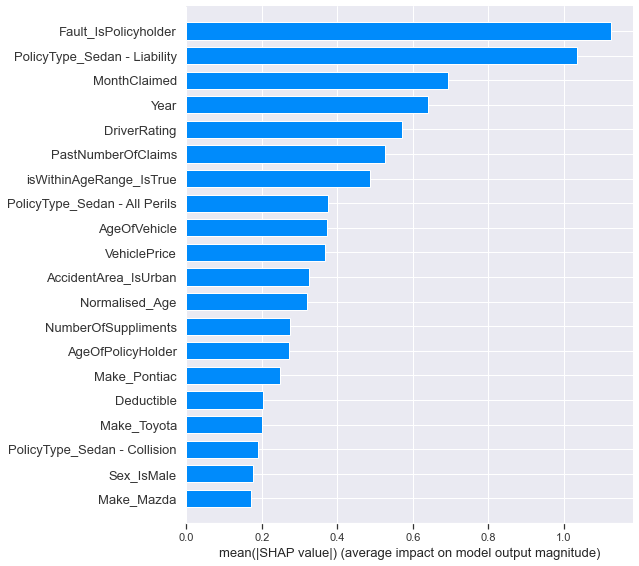

In [103]:
#featuere importance
shap.summary_plot(shap_values, X_display, plot_type="bar")

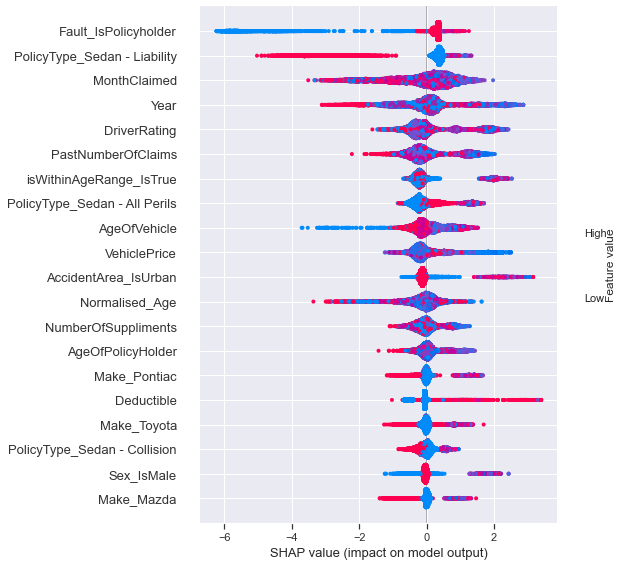

In [104]:
#plot a summary plot of all the features and how the value of the feaures affect SHAP value
shap.summary_plot(shap_values, X_train_resampled,features)